# Module 1. Personalize User-Item Interaction Data 준비 및 환경 설정


## Library Import 

파이썬에는 광범위한 라이브러리 모음이 포함되어 있으며, 본 LAB을 위해서 핵심 Data Scientist용 Tool 인 boto3 (AWS SDK) 및 Pandas/Numpy와 같은 라이브러리를 가져와야 합니다. 

In [1]:
# Imports
#!pip install jsonlines
#from codes import lambda_personalize
import boto3
import json
import numpy as np
import pandas as pd
import time
import jsonlines
import os

from datetime import datetime
import sagemaker
import time
import warnings

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
from botocore.exceptions import ClientError

다음으로 여러분의 환경이 Amazon Personalize와 성공적으로 통신할 수 있는지 확인해야 합니다.

In [2]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
s3 = boto3.resource('s3')

생성할 오브젝트의 끝에 임의의 숫자를 부여하기 위해 suffix 정의

In [3]:
# If you don't need profile, set USER_PROFILE=""
PROFILE_NAME="Customer"


WORK_DATE="20200710"
WORK_DATE_PATH="2020/07/10"

data_dir = "poc_data"
account_id = "870180618679"

#INTERACTION_FILE="interactions_" + WORK_DATE +".csv"
#INTERACTION_FILE_1="46b9579b-f217-4cb9-92cc-83cb9a0b0d0d.csv"

BUCKET_NAME = "customer-poc"
KEY_PREFIX = "hrnn-meta01"

PREFIX=WORK_DATE

INTERACTION_FILE="event/61bafa78-d05f-495a-b711-a9d517ed051a.csv"
USER_FILE="user/85c22025-c19f-4624-b6c1-bdbd6509f4b3.csv"
ITEM_FILE="item/018b720a-f8a1-4904-be7f-4c1334ad4bae.csv"


DATA_BUCKET_NAME = "customer-poc"
bucket=DATA_BUCKET_NAME 
#bucket_name = DATA_BUCKET_NAME
ROLE_NAME = "Customer-PersonalizeRetailRole-0612"
DATA_PREFIX = "dataset"
BATCH_PREFIX= "batch"
#INTERACTIONS="interaction_" + WORK_DATE + ".csv"
#MEMBERS="member_" + WORK_DATE + ".csv"
#PRODUCTS="product_" + WORK_DATE + ".csv"

DATA_SET_GROUP_NAME= WORK_DATE+ "-dataset-group"
SCHEMA_NAME_INTERACTION= WORK_DATE+ "-schema-interactions"
#SCHEMA_NAME_USERS= PREFIX + "-schema-users"
#SCHEMA_NAME_ITEMS= PREFIX + "-schema-items"

DATASET_NAME_INTERACTION="customer-dataset-interactions"
DATASET_NAME_USERS="customer-dataset-users"
DATASET_NAME_ITEMS="kurly-dataset-items"

suffix = str(np.random.uniform())[4:9]

BATCH_TARGET_USERS_FILE= "users_for_batch_"+ WORK_DATE + ".json"


## Interaction Data 다운로드 

In [4]:
target_file_path = data_dir+"/"+PREFIX+"/"+'event'
os.makedirs(target_file_path,exist_ok=True)
print(target_file_path)
source_file = KEY_PREFIX +"/"+PREFIX+"/"+INTERACTION_FILE
target_file = data_dir+"/"+PREFIX+"/"+INTERACTION_FILE

#s3.Bucket(BUCKET_NAME).download_file('kurly/data03/user+identifier/2020/06/12/46b9579b-f217-4cb9-92cc-83cb9a0b0d0d.csv', target_file_path)
s3.Bucket(BUCKET_NAME).download_file(source_file, target_file)


poc_data/20200710/event


In [5]:
#df_1=pd.read_csv('poc_data/46b9579b-f217-4cb9-92cc-83cb9a0b0d0d.csv')
#df_2=pd.read_csv('poc_data/f1355121-d9fe-4aaa-b3df-37f35f344384.csv')

df=pd.read_csv(target_file, usecols=['EVENT_TYPE','USER_ID','ITEM_ID','TIMESTAMP'])
#print(df_1.head())
#print(df_2.head())
#df=pd.concat(df_1, df_2)
#df.columns=['EVENT_TYPE','USER_ID','ITEM_ID','TIMESTAMP']
df_origin=df
df.head()


,EVENT_TYPE,USER_ID,ITEM_ID,TIMESTAMP
0,click,162509,37371.0,1.590775e+12
1,click,161673,7486.0,1.590774e+12
2,click,160726,31226.0,1.590772e+12
3,click,1189032,141.0,1.590772e+12
4,click,1201660,28628.0,1.590773e+12


In [6]:
df=df_origin.copy()
df.dtypes

EVENT_TYPE     object
USER_ID         int64
ITEM_ID       float64
TIMESTAMP     float64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60160726 entries, 0 to 60160725
Data columns (total 4 columns):
EVENT_TYPE    object
USER_ID       int64
ITEM_ID       float64
TIMESTAMP     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ GB


### NULL DATA제거 

In [8]:
print("# of rows of Null TimeStamp : {}".format(df['TIMESTAMP'].isnull().sum()))
print("# of rows of Null Event Type : {}".format(df['EVENT_TYPE'].isnull().sum()))
print("# of rows of Null User ID : {}".format(df['USER_ID'].isnull().sum()))
print("# of rows of Null Item ID : {}".format(df['ITEM_ID'].isnull().sum()))
#df[df['TIMESTAMP'].isnull()]

#########전체 INTERACTION 'null' 확인##########
#row_has_NaN = is_NaN.any(axis=1)
#rows_with_NaN = df[row_has_NaN]
#print(rows_with_NaN)
#len(rows_with_NaN)
##############################################

# of rows of Null TimeStamp : 323054
# of rows of Null Event Type : 0
# of rows of Null User ID : 0
# of rows of Null Item ID : 44


In [9]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59837630 entries, 0 to 60160725
Data columns (total 4 columns):
EVENT_TYPE    object
USER_ID       int64
ITEM_ID       float64
TIMESTAMP     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.2+ GB


### 데이터 타입 확인 및 변경

In [10]:
###Test Code to see timestamp format
#arb_time_stamp = df.iloc[50]['TIMESTAMP']
#print(arb_time_stamp)
#print(datetime.utcfromtimestamp(arb_time_stamp).strftime('%Y-%m-%d %H:%M:%S'))


In [11]:
df.TIMESTAMP  = df.TIMESTAMP / 1000
arb_time_stamp = df.iloc[50]['TIMESTAMP']
print(arb_time_stamp)
print(datetime.utcfromtimestamp(arb_time_stamp).strftime('%Y-%m-%d %H:%M:%S'))

1589385199.831
2020-05-13 15:53:19


In [12]:

print("from",datetime.utcfromtimestamp(df['TIMESTAMP'].min()).strftime('%Y-%m-%d %H:%M:%S'), "to", datetime.utcfromtimestamp(df['TIMESTAMP'].max()).strftime('%Y-%m-%d %H:%M:%S') )

from 2020-04-21 04:39:00 to 2020-05-31 15:00:01


In [14]:
df.EVENT_TYPE = df.EVENT_TYPE .astype(str)
df.ITEM_ID = df.ITEM_ID.astype(str)
df.USER_ID = df.USER_ID.astype(str)
df.TIMESTAMP=df.TIMESTAMP.astype('int64')

In [15]:
#item,item_unique=pd.factorize(df['ITEM_ID'])
#user,user_unique=pd.factorize(df['USER_ID'])
#df['ITEM_ID']=item
#df['USER_ID']=user

In [16]:
df.tail()

,EVENT_TYPE,USER_ID,ITEM_ID,TIMESTAMP
60160721,click,495101,17480.0,1590149226
60160722,click,302238,35325.0,1590149226
60160723,click,491361,29240.0,1590149235
60160724,click,62776,33293.0,1590150628
60160725,order,63991,34291.0,1590150634


In [17]:
#item_unique=pd.DataFrame(item_unique,columns=['ITEM_ID'])
#user_unique=pd.DataFrame(user_unique,columns=['USER_ID'])
item_unique=df.ITEM_ID.unique()
user_unique=df.USER_ID.unique()
item_unique=pd.DataFrame(item_unique)
user_unique=pd.DataFrame(user_unique)
item_unique.to_csv(data_dir+"/" + WORK_DATE+"/"+"unique_item_index.csv")
user_unique.to_csv(data_dir+"/" + WORK_DATE+"/"+"unique_user_index.csv")

###  INTERACTION DATA 정보 확인

Personalize에서 학습을 수행하기 위해서는 다음과 [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html)같은 데이터 요구사항을 맞추어야 합니다. 

* 최소 25명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 2개 이상의 Interaction(예. 구매,평가 등) 기록


하지만 일반적으로 다음과 같은 데이터가 준비 되어 있는것이 좋습니다. 

* 최소 50명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 24 이상의 Interaction(예. 구매,평가 등) 기록

In [18]:
unique_items = df['ITEM_ID'].unique()
unique_users = df['USER_ID'].unique()
print("unique_items: {}, Unique_users : {}".format(len(unique_items),len(unique_users)))

unique_items: 10479, Unique_users : 1538172


In [19]:
df.head()

,EVENT_TYPE,USER_ID,ITEM_ID,TIMESTAMP
0,click,162509,37371.0,1590774863
1,click,161673,7486.0,1590774201
2,click,160726,31226.0,1590772203
3,click,1189032,141.0,1590771794
4,click,1201660,28628.0,1590773149


click    49514094
order    10323536
Name: EVENT_TYPE, dtype: int64


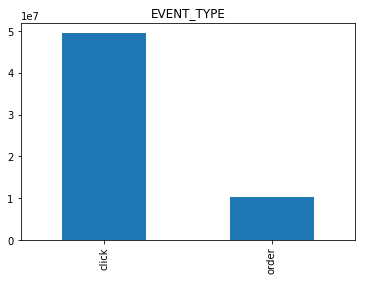

In [20]:
#for col in category_feature:
#    print("%s column is processing" % (col))
print(df.EVENT_TYPE.value_counts())
df.EVENT_TYPE.value_counts().plot(kind='bar')
plt.title("EVENT_TYPE")

plt.show()

In [21]:
user_activity_counts = df.groupby("USER_ID").count().loc[:,["EVENT_TYPE"]].rename(columns={"EVENT_TYPE":"INTERACTION_COUNTS"})
print(user_activity_counts.info())
user_activity_counts.head()


<class 'pandas.core.frame.DataFrame'>
Index: 1538172 entries, 1 to 999999
Data columns (total 1 columns):
INTERACTION_COUNTS    1538172 non-null int64
dtypes: int64(1)
memory usage: 23.5+ MB
None


,INTERACTION_COUNTS
USER_ID,
1,413
10,2717
100,538
1000,107
10000,5


In [22]:
user_activity_counts.quantile([.1,.2,.3,.4,.5,.6,.8,.9,.95,.99,.999,.9999,1.0])

,INTERACTION_COUNTS
0.1000,1.0000
0.2000,2.0000
0.3000,4.0000
0.4000,7.0000
0.5000,12.0000
0.6000,19.0000
0.8000,52.0000
0.9000,100.0000
0.9500,164.0000
0.9900,374.0000


In [23]:
user_activity_counts=user_activity_counts.reset_index()
activities = user_activity_counts.groupby('INTERACTION_COUNTS').count()
activities.columns=['NUM_USERS']
activities.head()

,NUM_USERS
INTERACTION_COUNTS,
1,204284
2,125551
3,89083
4,69315
5,56924


In [24]:
assert (len(unique_users)==activities['NUM_USERS'].sum())

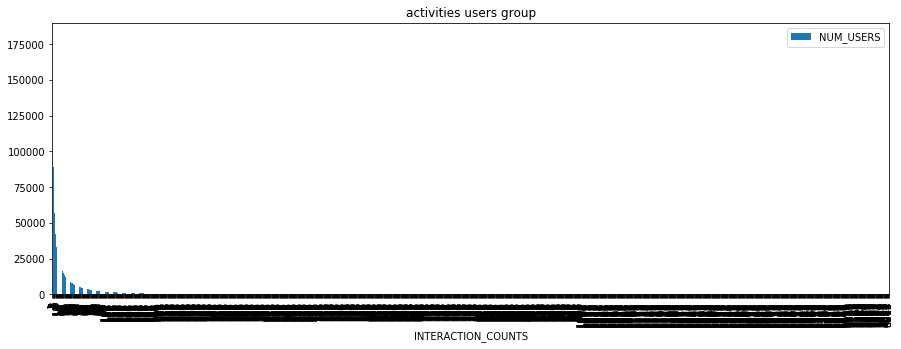

In [25]:
activities.loc[:8712,:].plot(kind='bar', figsize=(15,5), ylim=(0,190000))
plt.title("activities users group")

plt.show()

In [26]:
activities[activities.index > 24].NUM_USERS.sum()

536441

In [27]:
df.groupby("USER_ID").count().mean()

EVENT_TYPE    38.901781
ITEM_ID       38.901781
TIMESTAMP     38.901781
dtype: float64

In [28]:
#user_activity_counts['INTERACTION_COUNTS'].max()
heavy_user=user_activity_counts[user_activity_counts['INTERACTION_COUNTS']>1518]
heavy_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 1 to 1536017
Data columns (total 2 columns):
USER_ID               237 non-null object
INTERACTION_COUNTS    237 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.6+ KB


In [29]:
#user_activity_counts['INTERACTION_COUNTS'].max()
slow_user=user_activity_counts[user_activity_counts['INTERACTION_COUNTS']<=24]
print(slow_user.info())
print("slow_user_percentage:{}".format(len(slow_user)/len(user_activity_counts)))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001731 entries, 4 to 1538171
Data columns (total 2 columns):
USER_ID               1001731 non-null object
INTERACTION_COUNTS    1001731 non-null int64
dtypes: int64(1), object(1)
memory usage: 22.9+ MB
None
slow_user_percentage:0.6512477148199292


### 아이템 분석

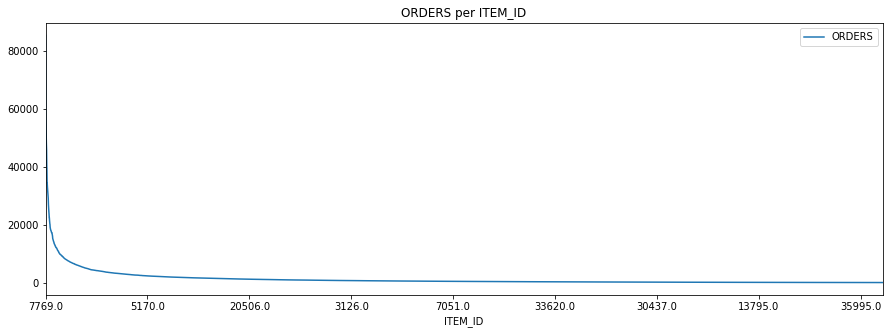

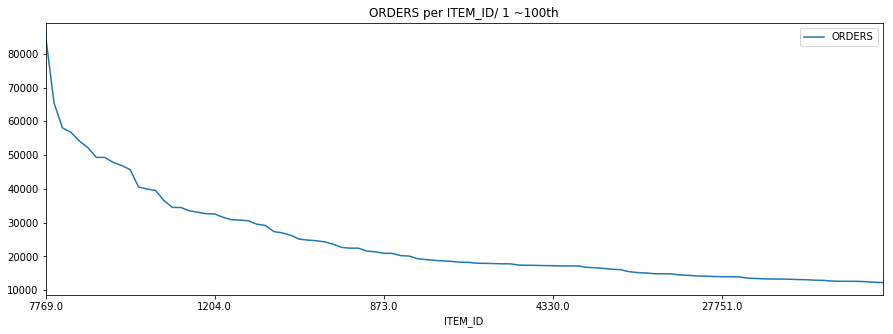

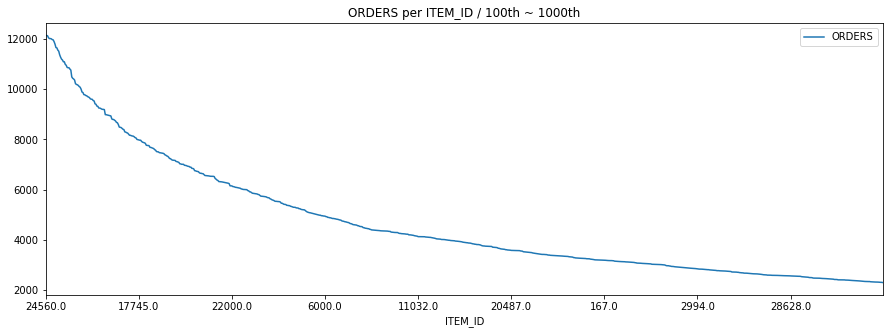

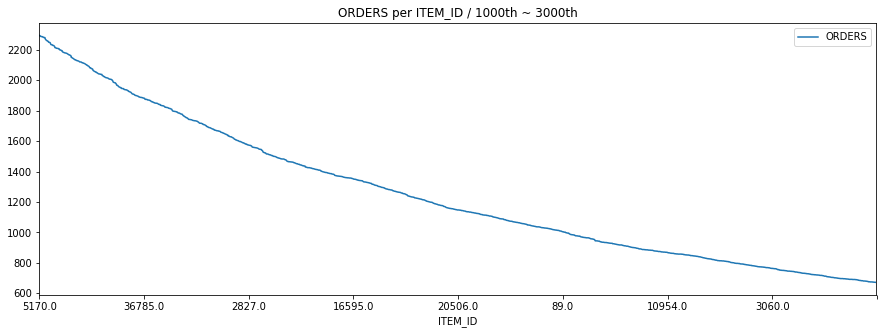

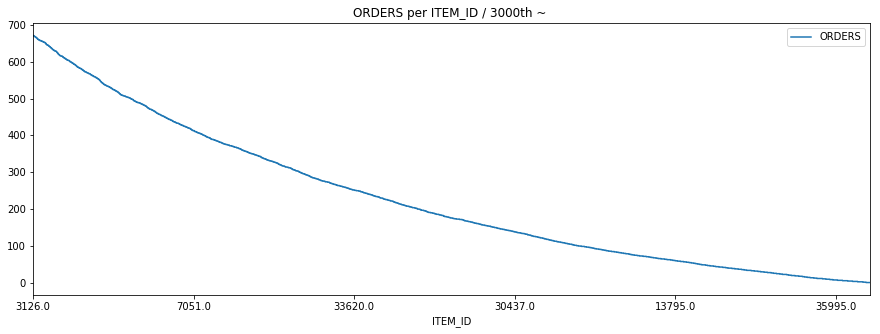

In [30]:
def draw_long_tails(df, is_in_event_types, groupby_column_name, count_name, range1=100, range2=1000, range3=3000):
    filtered_df = df.loc[df["EVENT_TYPE"].isin(is_in_event_types)]
    groupby_df = filtered_df.groupby(groupby_column_name).count().loc[:,["EVENT_TYPE"]].rename(columns={"EVENT_TYPE":count_name})
    sorted_df = groupby_df.sort_values([count_name], ascending=False)
    
    sorted_df[:].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name)
    plt.show()

    sorted_df[:range1].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + "/ 1 ~" + str(range1) + "th")
    plt.show()
    
    sorted_df[range1:range2].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + " / " + str(range1) + "th ~ "+ str(range2) + "th")
    plt.show()

    sorted_df[range2:range3].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + " / " + str(range2) + "th ~ "+ str(range3) + "th")
    plt.show()
    
    sorted_df[range3:].plot(kind='line', figsize=(15,5))
    plt.title(count_name + " per " + groupby_column_name + " / " + str(range3) + "th ~ ")
    plt.show()
    
#draw_long_tails(interactions_org, ["order"], "ITEM_ID", "ORDERS", 100, 1000, 3000)
draw_long_tails(df, ["order"], "ITEM_ID", "ORDERS", 100, 1000, 3000)

## User Data 분석

In [31]:
target_file_path = data_dir+"/"+PREFIX+"/"+'user'
os.makedirs(target_file_path,exist_ok=True)
source_file = KEY_PREFIX +"/"+PREFIX+"/"+USER_FILE
target_file = data_dir+"/"+PREFIX+"/"+USER_FILE

#s3.Bucket(BUCKET_NAME).download_file('kurly/data03/user+identifier/2020/06/12/46b9579b-f217-4cb9-92cc-83cb9a0b0d0d.csv', target_file_path)
s3.Bucket(BUCKET_NAME).download_file(source_file, target_file)

In [32]:
users=pd.read_csv(target_file)
users.columns=['USER_ID','LEVEL']
users.head()


,USER_ID,LEVEL
0,21658,1
1,1483526,20
2,250253,1
3,257988,1
4,250019,1


In [33]:
users.USER_ID = users.USER_ID.astype(str)
users.LEVEL = users.LEVEL.astype(str)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175631 entries, 0 to 1175630
Data columns (total 2 columns):
USER_ID    1175631 non-null object
LEVEL      1175631 non-null object
dtypes: object(2)
memory usage: 17.9+ MB


In [34]:
user_level_counts = users.groupby('LEVEL').count().loc[:,["USER_ID"]].rename(columns={"USER_ID":"USER_LEVEL_COUNTS"})
user_level_counts

,USER_LEVEL_COUNTS
LEVEL,
1,893800
11,1004
12,2227
14,14317
15,26568
16,63311
20,135271
5,39127
81,4


## Item 데이터 분석 

In [35]:
target_file_path = data_dir+"/"+PREFIX+"/"+'item'
os.makedirs(target_file_path,exist_ok=True)

source_file = KEY_PREFIX +"/"+PREFIX+"/"+ITEM_FILE
target_file = data_dir+"/"+PREFIX+"/"+ITEM_FILE

#s3.Bucket(BUCKET_NAME).download_file('kurly/data03/user+identifier/2020/06/12/46b9579b-f217-4cb9-92cc-83cb9a0b0d0d.csv', target_file_path)
s3.Bucket(BUCKET_NAME).download_file(source_file, target_file)


In [36]:
items=pd.read_csv(target_file)
items_origin=items
items.head()


,KURLY_ONLY,KEEP_TYPE,MAIN_CATEGORY,MIDDLE_CATEGORY,ITEM_ID
0,0,COLD,채소/과일/곡류,채소,6
1,0,COLD,채소/과일/곡류,채소,7
2,0,COLD,채소/과일/곡류,채소,8
3,1,ROOM,채소/과일/곡류,과일,9
4,0,COLD,정육/달걀,달걀,10


In [42]:
items=items_origin.copy()
items=items[["ITEM_ID","MIDDLE_CATEGORY"]]
items.head()

,ITEM_ID,MIDDLE_CATEGORY
0,6,채소
1,7,채소
2,8,채소
3,9,과일
4,10,달걀


In [43]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 2 columns):
ITEM_ID            30161 non-null int64
MIDDLE_CATEGORY    30110 non-null object
dtypes: int64(1), object(1)
memory usage: 471.3+ KB


In [44]:
item_middlecat_counts = items.groupby('MIDDLE_CATEGORY').count().loc[:,["ITEM_ID"]].rename(columns={"ITEM_ID":"MIDDLECAT_COUNTS"})
item_middlecat_counts 

,MIDDLECAT_COUNTS
MIDDLE_CATEGORY,
Kurly's Kitchen,79
간편식/간편조리,1823
건어물,170
견과류,235
과일,626
국/찌개/탕,233
기저귀/물티슈,191
기타,4149
김/해조류,151


In [45]:
print("# of rows of Null ITEM_ID : {}".format(items['ITEM_ID'].isnull().sum()))
#print("# of rows of Null MAIN_CATEGORY : {}".format(items['MAIN_CATEGORY'].isnull().sum()))
#print("# of rows of Null KURLY_ONLY : {}".format(items['KURLY_ONLY'].isnull().sum()))
print("# of rows of Null MIDDLE_CATEGORY : {}".format(items['MIDDLE_CATEGORY'].isnull().sum()))

# of rows of Null ITEM_ID : 0
# of rows of Null MIDDLE_CATEGORY : 51


In [47]:
items.ITEM_ID = items.ITEM_ID.astype(str)

In [49]:

for i,item in enumerate(items["MIDDLE_CATEGORY"]):
    if (not item  or pd.isnull(item)):
        pass
    else:
        items["MIDDLE_CATEGORY"][i]=item.replace('/', '|') 
 

In [50]:
item_middlecat_counts = items.groupby('MIDDLE_CATEGORY').count().loc[:,["ITEM_ID"]].rename(columns={"ITEM_ID":"MIDDLECAT_COUNTS"})
item_middlecat_counts 

,MIDDLECAT_COUNTS
MIDDLE_CATEGORY,
Kurly's Kitchen,79
간편식|간편조리,1823
건어물,170
견과류,235
과일,626
국|찌개|탕,233
기저귀|물티슈,191
기타,4149
김|해조류,151


In [ ]:
#item_maincat_counts = items.groupby('MAIN_CATEGORY').count().loc[:,["ITEM_ID"]].rename(columns={"ITEM_ID":"MAINCAT_COUNTS"})
#item_maincat_counts 


### 데이터 S3 업로드 

In [51]:
# File upload에 몇분 소요 (600MB)

local_dataset_path=data_dir+"/"+WORK_DATE+"/"+"training"+"/"
os.makedirs(local_dataset_path,exist_ok=True)

interaction_object_key = "interactions_" + WORK_DATE + ".csv"
user_object_key="users_"+ WORK_DATE + ".csv"
item_object_key="items_"+WORK_DATE + ".csv"

interaction_file=local_dataset_path+"/"+interaction_object_key
user_file=local_dataset_path+"/"+user_object_key
item_file=local_dataset_path+"/"+item_object_key

df[["USER_ID","ITEM_ID","TIMESTAMP","EVENT_TYPE"]].to_csv(interaction_file,index=False)
users.to_csv(user_file,index=False)
items.to_csv(item_file,index=False)

In [52]:
target=KEY_PREFIX+"/"+DATA_PREFIX+"/"+interaction_object_key
boto3.Session().resource('s3').Bucket(DATA_BUCKET_NAME).Object(target).upload_file(interaction_file)

target=KEY_PREFIX+"/"+DATA_PREFIX+"/"+user_object_key
boto3.Session().resource('s3').Bucket(DATA_BUCKET_NAME).Object(target).upload_file(user_file)


target=KEY_PREFIX+"/"+DATA_PREFIX+"/"+item_object_key
boto3.Session().resource('s3').Bucket(DATA_BUCKET_NAME).Object(target).upload_file(item_file)

## 스키마 생성

Personalize가 데이터를 이해하는 방법의 핵심 구성 요소는 아래 정의 된 스키마(schema)에서 비롯됩니다. 이 설정은 CSV 파일을 통해 제공된 데이터를 요약하는 방법을 Personalize 서비스에 알려줍니다. 열(column)과 유형(type)은 위에서 만든 파일의 내용과 일치합니다.

### Interaction 스키마 생성

In [53]:
interaction_schema_name="Interaction-schema-"+WORK_DATE+"-"+suffix

In [54]:
interaction_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
       
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        { 
            "name": "EVENT_TYPE",
            "type": "string"
        },
    ],
    "version": "1.0"
}


create_schema_response = personalize.create_schema(
    name = interaction_schema_name,
    schema = json.dumps(interaction_schema)
)

interaction_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-northeast-2:870180618679:schema/Interaction-schema-20200710-40722",
  "ResponseMetadata": {
    "RequestId": "6b072c0a-297f-43fd-b9bf-33ea1f0a8d89",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 10 Jul 2020 09:05:48 GMT",
      "x-amzn-requestid": "6b072c0a-297f-43fd-b9bf-33ea1f0a8d89",
      "content-length": "104",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### User 스키마 생성

In [55]:
user_schema_name="User-schema-"+WORK_DATE+"-"+suffix

In [56]:
user_schema = {
    "type": "record",
    "name": "Users",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
      {
          "name": "LEVEL",
          "type": "string",
          "categorical": True
      }
     
    ],
    "version": "1.0"
}


create_schema_response = personalize.create_schema(
    name = user_schema_name,
    schema = json.dumps(user_schema)
)

user_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-northeast-2:870180618679:schema/User-schema-20200710-40722",
  "ResponseMetadata": {
    "RequestId": "b333cb0c-d5a4-4498-ae91-96ad20cf4c74",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 10 Jul 2020 09:05:48 GMT",
      "x-amzn-requestid": "b333cb0c-d5a4-4498-ae91-96ad20cf4c74",
      "content-length": "97",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
item_schema_name="Item-schema-"+WORK_DATE+"-"+suffix

In [57]:
item_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
    {
        "name": "ITEM_ID",
        "type": "string"
    },
   
    
    {
        "name": "MIDDLE_CATEGORY",
        "type": ["string","null"],
        "categorical": True
    }
    
      
        
    ],
    "version": "1.0"
}

create_metadata_schema_response = personalize.create_schema(
    name = item_schema_name,
    schema = json.dumps(item_schema)
)

item_schema_arn = create_metadata_schema_response['schemaArn']
print(json.dumps(create_metadata_schema_response, indent=2))


NameError: name 'item_schema_name' is not defined

## 데이터 세트 그룹 생성 및 대기

Personalize에서 가장 큰 단위는 **데이터 세트 그룹(Dataset Group)** 이며, 이렇게 하면 데이터, 이벤트 추적기(event tracker), 솔루션(solution) 및 캠페인(campaign)이 분리됩니다. 공통의 데이터 수집을 공유하는 것들을 그룹화합니다. 원하는 경우 아래 그룹명을 자유롭게 변경해 주세요.

### 데이터 세트 그룹 생성

In [ ]:
create_dataset_group_response = personalize.create_dataset_group(
    name = DATA_SET_GROUP_NAME
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

#### 데이터 세트 그룹이 활성화 상태가 될 때까지 대기

아래의 모든 항목에서 Dataset Group을 사용하려면 활성화(active)가 되어야 합니다. 아래 셀을 실행하고 DatasetGroup: ACTIVE로 변경될 때까지 기다려 주세요.

In [ ]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

### 데이터 세트 생성

그룹 다음으로 생성할 것은 실제 데이터 세트입니다. 아래의 코드 셀을 실행하여 데이터 세트을 생성해 주세요.

### Interaction 데이터 세트 생성

In [ ]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = DATASET_NAME_INTERACTION,
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interaction_schema_arn
)

interaction_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

###  USER 데이터 세트 생성 

In [ ]:
dataset_type = "USERS"

create_dataset_response = personalize.create_dataset(
    name = DATASET_NAME_USERS,
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = user_schema_arn
)

user_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

### ITEM 데이터 세트 생성

In [ ]:
dataset_type = "ITEMS"

create_dataset_response = personalize.create_dataset(
    name = DATASET_NAME_ITEMS,
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = item_schema_arn
)

item_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

### S3 버킷에 정책 부여

Amazon Personalize는 앞서 생성한 S3 버킷의 내용을 읽을 수 있어야 합니다. 아래 코드 셀로 S3 버킷 접근 정책(policy)을 부여합니다.

In [ ]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket",
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=DATA_BUCKET_NAME, Policy=json.dumps(policy))

### Personalize IAM Role 생성

또한, Amazon Personalize는 특정 작업들을 실행할 권한을 갖기 위해, AWS에서 역할을 맡을 수 있는 기능이 필요합니다. 

In [ ]:
role_arn="arn:aws:iam::870180618679:role/Kurly-PersonalizeRetailRole-0612"
'''
iam = boto3.client("iam")

role_name = ROLE_NAME
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}




try:
    create_role_response = iam.create_role(
        RoleName = role_name,
        AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
    );

    iam.attach_role_policy(
        RoleName = role_name,
        PolicyArn = "arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
    );

    role_arn = create_role_response["Role"]["Arn"]
except ClientError as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        role_arn = iam.get_role(RoleName=role_name)['Role']['Arn']
    else:
        raise
        

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    RoleName=role_name,    
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess'
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate


print(role_arn)
'''

### 데이터 세트 Import

이전에는 정보를 저장하기 위해 데이터 세트 그룹 및 데이터 세트를 생성했으므로, 
이제는 모델 구축을 위해 S3에서 Amazon Personalize로 데이터를 로드하는 import job을 실행합니다.

#### Interaction 데이터 세트 Import Job 생성

In [ ]:
print(DATA_BUCKET_NAME, KEY_PREFIX+"/"+DATA_PREFIX+"/"+interaction_object_key)

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "kurly-interaction-dataset-import-" + WORK_DATE,
    datasetArn = interaction_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(DATA_BUCKET_NAME, KEY_PREFIX+"/"+DATA_PREFIX+"/"+interaction_object_key)
    },
    roleArn = role_arn
)

interation_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "kurly-users-dataset-import-" + WORK_DATE,
    datasetArn = user_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(DATA_BUCKET_NAME, KEY_PREFIX+"/"+DATA_PREFIX+"/"+user_object_key)
    },
    roleArn = role_arn
)

user_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "kurly-item-dataset-import-" + WORK_DATE,
    datasetArn = item_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(DATA_BUCKET_NAME, KEY_PREFIX+"/"+DATA_PREFIX+"/"+item_object_key)
    },
    roleArn = role_arn
)

item_dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

In [ ]:
#store values 세션 끊길거 대비 
%store BUCKET_NAME
%store DATA_BUCKET_NAME
%store dataset_group_arn
%store interaction_dataset_arn
%store user_dataset_arn
%store item_dataset_arn
%store interation_dataset_import_job_arn
%store user_dataset_import_job_arn
%store item_dataset_import_job_arn
%store ROLE_NAME
%store role_arn

#### 아이템 데이터 세트 Import Job 생성

### 데이터 세트 Import job이 활성화 상태가 될 때까지 대기

Import job이 완료되기까지 시간이 걸립니다. 아래 코드 셀의 출력 결과가 DatasetImportJob: ACTIVE가 될 때까지 기다려 주세요.

In [ ]:
%%time

status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = interation_dataset_import_job_arn
    )
    
    dataset_import_job = describe_dataset_import_job_response["datasetImportJob"]
    if "latestDatasetImportJobRun" not in dataset_import_job:
        status = dataset_import_job["status"]
        print("DatasetImportJob: {}".format(status))
    else:
        status = dataset_import_job["latestDatasetImportJobRun"]["status"]
        print("LatestDatasetImportJobRun: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

## 솔루션 생성 

In [ ]:
 # Recipe 선택 
hrnn_recipe_arn = "arn:aws:personalize:::recipe/aws-hrnn-metadata"

In [ ]:
# Solution 생성 
create_solution_response = personalize.create_solution(
    name = "Kurly-hrnn-" + WORK_DATE,
    datasetGroupArn = dataset_group_arn,
    recipeArn = hrnn_recipe_arn,
)

hrnn_solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

In [ ]:
# 솔루션 버전 생성
create_solution_version_response = personalize.create_solution_version(
    solutionArn = hrnn_solution_arn
)

hrnn_solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

In [ ]:
%%time

max_time = time.time() + 8*60*60 # 8 hours
while time.time() < max_time:
      
    #hrnn status
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = hrnn_solution_version_arn
    )  
    status_hrnn = describe_solution_version_response["solutionVersion"]["status"]
    print("HRNN SolutionVersion: {}".format(status_hrnn))
       
    if  (status_hrnn == "ACTIVE" or status_hrnn == "CREATE FAILED"):
        break
 
    time.sleep(300)

print("All solution creation completed")

In [ ]:
%store hrnn_solution_version_arn
%store hrnn_solution_arn


## 솔루션 평가하기 

In [ ]:
%store -r

In [ ]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = hrnn_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))



## Batch Inference

In [ ]:
batch_target_users = df.USER_ID.unique()

BATCH_TARGET_USERS_FILE= "users_for_batch_"+ WORK_DATE + ".json"

n = 0
f = open(data_dir+"/"+BATCH_TARGET_USERS_FILE,"w")
for user in batch_target_users:
    f.write("{\"userId\":\"%s\"}\n" % user)
    n = n + 1
    #for the test
    #if n> 100:
    #    break
    
f.close()
print(BATCH_TARGET_USERS_FILE)
print(n)

In [ ]:
# Upload files to S3
S3_BATCH_FILE_PATH=KEY_PREFIX+"/"+"batch"+"/"

boto3.Session().resource('s3').Bucket(DATA_BUCKET_NAME).Object(S3_BATCH_FILE_PATH+BATCH_TARGET_USERS_FILE).upload_file(data_dir+"/"+BATCH_TARGET_USERS_FILE)

s3_input_path = "s3://" + DATA_BUCKET_NAME + "/"+S3_BATCH_FILE_PATH+BATCH_TARGET_USERS_FILE
print(s3_input_path)

In [ ]:
# Define the output path
s3_output_path = "s3://" +DATA_BUCKET_NAME +"/"+S3_BATCH_FILE_PATH
print(s3_output_path)

In [ ]:
batchInferenceJobArn = personalize.create_batch_inference_job (
    solutionVersionArn = hrnn_solution_version_arn,
    jobName = "Kurly-Batch-Inference-Job-HRNN-"+WORK_DATE+suffix,
    roleArn = role_arn,
    jobInput = 
     {"s3DataSource": {"path": s3_input_path}},
    jobOutput = 
     {"s3DataDestination":{"path": s3_output_path}}
)
batchInferenceJobArn = batchInferenceJobArn['batchInferenceJobArn']

In [ ]:
current_time = datetime.now()
print("Import Started on: ", current_time.strftime("%I:%M:%S %p"))

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_inference_job_response = personalize.describe_batch_inference_job(
        batchInferenceJobArn = batchInferenceJobArn
    )
    status = describe_dataset_inference_job_response["batchInferenceJob"]['status']
    print("DatasetInferenceJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)
    
current_time = datetime.now()
print("Import Completed on: ", current_time.strftime("%I:%M:%S %p"))

In [ ]:
s3 = boto3.client('s3')
export_name = BATCH_TARGET_USERS_FILE + ".out"

s3.download_file(DATA_BUCKET_NAME,S3_BATCH_FILE_PATH+export_name,data_dir+"/"+export_name)
print(S3_BATCH_FILE_PATH+export_name,data_dir+"/"+export_name)
# Update DF rendering
pd.set_option('display.max_rows', 30)
count=0
with open(data_dir+export_name) as json_file:
    # Get the first line and parse it
    line = json.loads(json_file.readline())
    # Do the same for the other lines
    while line:
        # extract the user ID 
        col_header = "User: " + line['input']['userId']
        # Create a list for all the artists
        recommendation_list = []
        # Add all the entries
        for item in line['output']['recommendedItems']:
            #title = get_movie_title(item)
            #recommendation_list.append(title)
            recommendation_list.append(item)
        if count>0:
            new_rec_DF = pd.DataFrame(recommendation_list, columns = [col_header])
            batch_recommendations_df = batch_recommendations_df.join(new_rec_DF)
            count+=1
        else:
            batch_recommendations_df = pd.DataFrame(recommendation_list, columns=[col_header])
            count+=1
        try:
            line = json.loads(json_file.readline())
        except:
            line = None
batch_recommendations_df
print(count)

In [ ]:

def read_batch_result(filename, key_name):
    result = {}
    fp = open(filename)
    reader = jsonlines.Reader(fp)
    count = 0
    for record in reader:
        result[record["input"][key_name]] = str.join(",",record["output"]["recommendedItems"])
        count += 1
    reader.close()
    fp.close()
    
    print("Found records:", count, len(result))
    return result

def unique_count(result):
    recommend_keys = {}
    
    duplicate_cnt = 0
    unique_cnt = 0
    for k in result:
        key = result[k]
        
        if key not in recommend_keys:
            unique_cnt += 1            
            recommend_keys[key] = { "count": 1, "keys": k }
        else:
            recommend_keys[key]["count"] = recommend_keys[key]["count"] + 1
            #recommend_keys[key]["keys"] = recommend_keys[key]["keys"] + "," + k
            duplicate_cnt += 1
        #print(f'dup:%10d, unique:%10d, %s is processing…\r' % (duplicate_cnt, unique_cnt, k), end="")

    return recommend_keys, unique_cnt, duplicate_cnt

hrnn_result = read_batch_result("poc_data/"+"users_for_batch_20200612.json.out", "userId")
recommend_keys, unique_cnt, duplicate_cnt = unique_count(hrnn_result)

print(f'dup:%10d, unique:%10d\n' % (duplicate_cnt, unique_cnt))
cnt = 10
for i in sorted(recommend_keys, key=lambda x: (recommend_keys[x]['count']), reverse=True):
    print(recommend_keys[i], i)
    if cnt < 0: 
        break
    cnt -=1

In [ ]:
%store batchInferenceJobArn

## 캠페인 생성하기 

In [ ]:
'''
create_campaign_response = personalize.create_campaign(
    name = "Customer-hrnn-campaign-" + WORK_DATE,
    solutionVersionArn = hrnn_solution_version_arn,
    minProvisionedTPS = 1
)

hrnn_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))
'''

In [ ]:
'''
user_id= test_user_id
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = hrnn_campaign_arn,
    userId = str(user_id),
)
# Update DF rendering
pd.set_option('display.max_rows', 30)

print("Recommendations for user: ", user_id)

item_list = get_recommendations_response['itemList']

recommendation_title_list = []
recommendation_id_list=[]
for item in item_list:
    recommendation_title_list.append(title)
    recommendation_id_list.append(item['itemId'])
recommendations_df = pd.DataFrame(recommendation_title_list, columns = ['OriginalRecs'])
recommendations_df
'''

In [ ]:
%store hrnn_campaign_arn
